In [1]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import math, os, re, warnings, random
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import tensorflow.keras.layers as L
from kaggle_datasets import KaggleDatasets
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
import efficientnet.tfkeras as efn
# from adabelief_tf import AdaBeliefOptimizer

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    
    
seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU@{}'.format(tpu.master()))
except ValueError:
    tpu = None
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
else:
    strategy = tf.distribute.get_strategy()
    
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync 
print('# REPLICAS: {}'.format(REPLICAS))

Running on TPU@grpc://10.0.0.2:8470
# REPLICAS: 8


In [4]:
BATCH_SIZE = 16 * REPLICAS
LEARNING_RATE = 3e-5 * REPLICAS
EPOCHS = 30
HEIGHT = 299
WIDTH = 299
CHANNELS = 3
N_CLASSES = 6
ES_PATIENCE = 10
N_FOLDS = 5
AUG_BATCH=BATCH_SIZE
IMAGE_SIZE=[HEIGHT,WIDTH]

In [5]:
GCS_PATH = KaggleDatasets().get_gcs_path('attentiveaitfrecords299x299')
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH+"/content/TFRECORDS/*.tfrec")

In [6]:
TRAINING_FILENAMES

['gs://kds-41cd598628cced911d7949166d44c0f3ecfd5db8f6170c05cf5f7a32/content/TFRECORDS/Merged_idx_1.tfrec',
 'gs://kds-41cd598628cced911d7949166d44c0f3ecfd5db8f6170c05cf5f7a32/content/TFRECORDS/Merged_idx_2.tfrec',
 'gs://kds-41cd598628cced911d7949166d44c0f3ecfd5db8f6170c05cf5f7a32/content/TFRECORDS/Merged_idx_3.tfrec',
 'gs://kds-41cd598628cced911d7949166d44c0f3ecfd5db8f6170c05cf5f7a32/content/TFRECORDS/Merged_idx_4.tfrec',
 'gs://kds-41cd598628cced911d7949166d44c0f3ecfd5db8f6170c05cf5f7a32/content/TFRECORDS/Merged_idx_5.tfrec',
 'gs://kds-41cd598628cced911d7949166d44c0f3ecfd5db8f6170c05cf5f7a32/content/TFRECORDS/Merged_idx_6.tfrec',
 'gs://kds-41cd598628cced911d7949166d44c0f3ecfd5db8f6170c05cf5f7a32/content/TFRECORDS/Merged_idx_7.tfrec']

In [7]:
CLASSES = ["Steel",
"Adhered",
"Concrete",
"Shingle",
"Plastic & fabric",
"Ballasted "]

In [8]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [9]:
def onehot(image,label):
#     print('LABEL = ',label)
    label = tf.cast(label,dtype=tf.int64)
#     print('LABEL = ',label)
    return image,tf.one_hot(label,6)

In [10]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)    
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
    # Pixel-level transforms
    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=.7, upper=1.3)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=.8, upper=1.2)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.1)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
    
    image,label = onehot(image,label)
    return image, label

In [11]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

In [12]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [13]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data,channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    channels = tf.unstack(image, axis=-1)
    image    = tf.stack([channels[2], channels[1], channels[0]], axis=-1)
    image = tf.image.resize(image,[HEIGHT,WIDTH])
    image = tf.reshape(image, [HEIGHT,WIDTH,3])
    
    return image



def read_tfrecord(example, labeled=True):
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'name': tf.io.FixedLenFeature([], tf.string),
            'label':tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = example['label']
    else:
        label_or_name =  example['name']
    return image, label_or_name

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    return dataset

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, augment=False,val=False):
    dataset = load_dataset(FILENAMES, labeled=labeled, ordered=ordered)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    if val:
        dataset = dataset.map(onehot,num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    
#     if augment:
#         dataset = dataset.map(transform,num_parallel_calls=AUTO)
    
    dataset = dataset.prefetch(AUTO)
    return dataset

In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt


np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    labels = [str(i) for i in  numpy_labels]
    # decoder = np.vectorize(lambda x: x.decode('UTF-8'))
    # numpy_labels = decoder(numpy_labels)
    # numpy_images = numpy_images[:,:,::-1]
    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        # image = cv2.imdecode(image,cv2.IMREA)
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
    
# Model evaluation
def plot_metrics(history):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 4))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

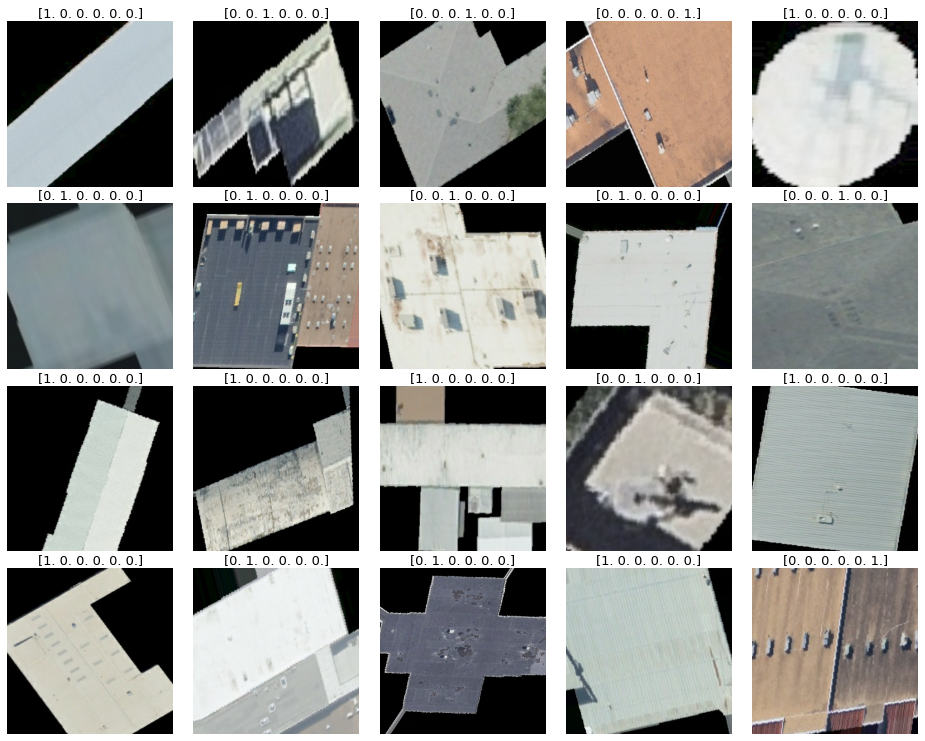

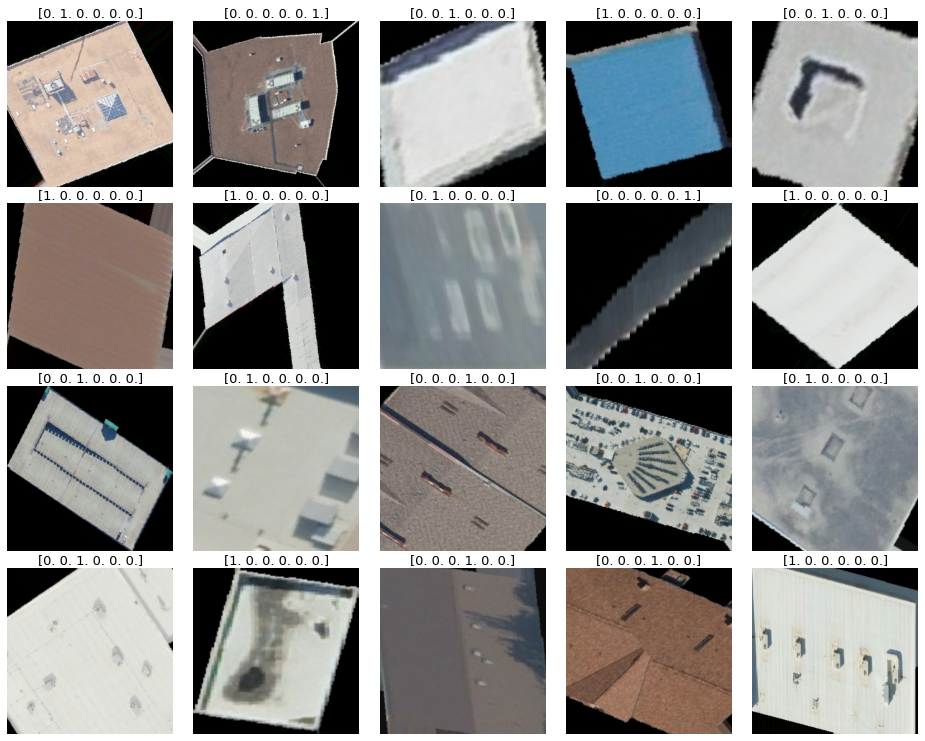

In [15]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True,augment=True,val=False)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

Learning rate schedule: 1e-08 to 0.00024 to 8.11e-07


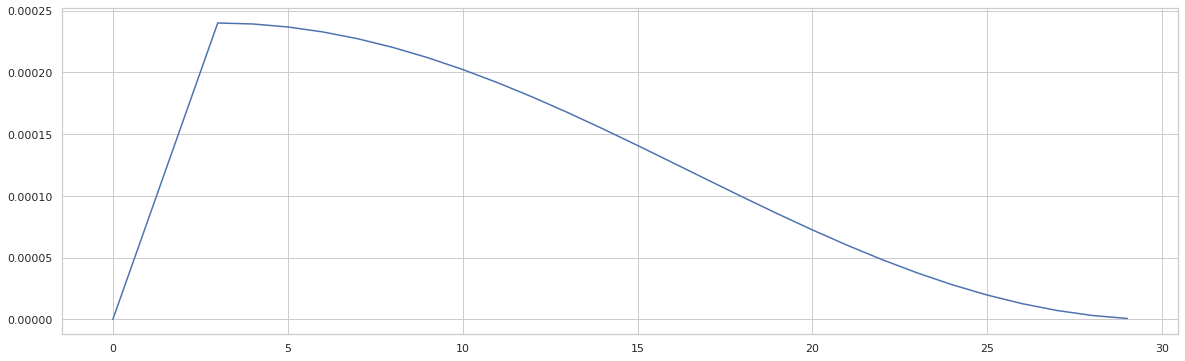

In [16]:
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5


def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

# print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [17]:
def model_fn(input_shape, N_CLASSES):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB4(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')


    for layer in base_model.layers:
        if 'bn' in layer.name:
            layer.trainable = False
        else:
            layer.trainable = True
            
    model = tf.keras.Sequential([
        base_model,
        L.Dropout(.25),
        L.Dense(N_CLASSES, activation='softmax', name='output')
    ])

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=losses.CategoricalCrossentropy(), 
                  metrics=['categorical_accuracy'])
    
    return model

In [18]:
def count_data_items(filenames):
    
    return 1234*len(filenames)

In [19]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(7))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    idxT = [i+1 for i in idxT]
    idxV = [i+1 for i in idxV]
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    TRAIN_FILENAMES = tf.io.gfile.glob([GCS_PATH+"/content/TFRECORDS" + '/Merged_idx_%.i*.tfrec' % x for x in idxT])
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH+"/content/TFRECORDS" + '/Merged_idx_%.i*.tfrec' % x for x in idxV])
    
    np.random.shuffle(TRAIN_FILENAMES)

    ct_train = count_data_items(TRAIN_FILENAMES)
    STEPS_PER_EPOCH = ct_train // BATCH_SIZE
    
    ## MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        
    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', 
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

    ## TRAIN
    history = model.fit(x=get_dataset(TRAIN_FILENAMES,ordered=False, repeated=True,augment = True,val= False), 
                        validation_data=get_dataset(VALID_FILENAMES, ordered=True, repeated=False,augment=False,val=True), 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        callbacks=[es, LearningRateScheduler(lrfn,verbose=0)], 
                        epochs=EPOCHS,
                        class_weight = {0: 0.62044215,1: 0.62070946,2: 1.25712624,3: 1.34390547,4: 1.34893883,5: 2.01491841},
                        verbose=1).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True, repeated=False,val=True,augment= False)
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, image_name: image)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))
    
    ## RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_categorical_accuracy']):.3f}")
        
#     else:
#         continue


FOLD: 1
TRAIN: [1, 2, 4, 5, 6] VALID: [3, 7]
71680000/71678424 [==============================] - 1s 0us/step
Epoch 1/30
48/48 [==============================] - 41s 857ms/step - categorical_accuracy: 0.1911 - loss: 1.8315 - val_categorical_accuracy: 0.1816 - val_loss: 1.8262 - lr: 1.0000e-08
Epoch 2/30
48/48 [==============================] - 13s 265ms/step - categorical_accuracy: 0.4491 - loss: 1.2888 - val_categorical_accuracy: 0.5761 - val_loss: 1.0671 - lr: 8.0007e-05
Epoch 3/30
48/48 [==============================] - 13s 267ms/step - categorical_accuracy: 0.6533 - loss: 0.8083 - val_categorical_accuracy: 0.7504 - val_loss: 0.6529 - lr: 1.6000e-04
Epoch 4/30
48/48 [==============================] - 11s 227ms/step - categorical_accuracy: 0.7121 - loss: 0.6717 - val_categorical_accuracy: 0.7411 - val_loss: 0.7512 - lr: 2.4000e-04
Epoch 5/30
48/48 [==============================] - 12s 260ms/step - categorical_accuracy: 0.7536 - loss: 0.5808 - val_categorical_accuracy: 0.8054 - val


FOLD: 1


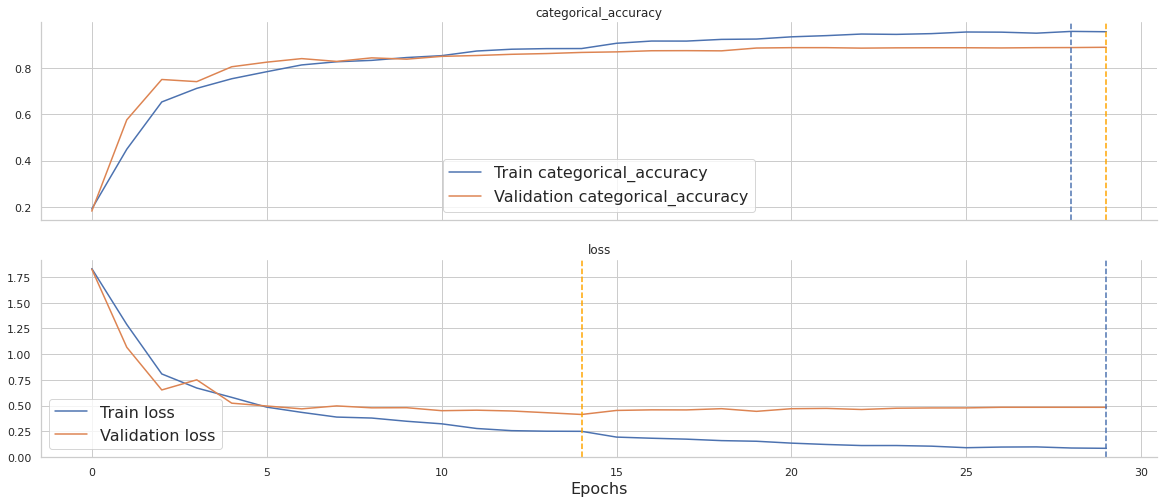


FOLD: 2


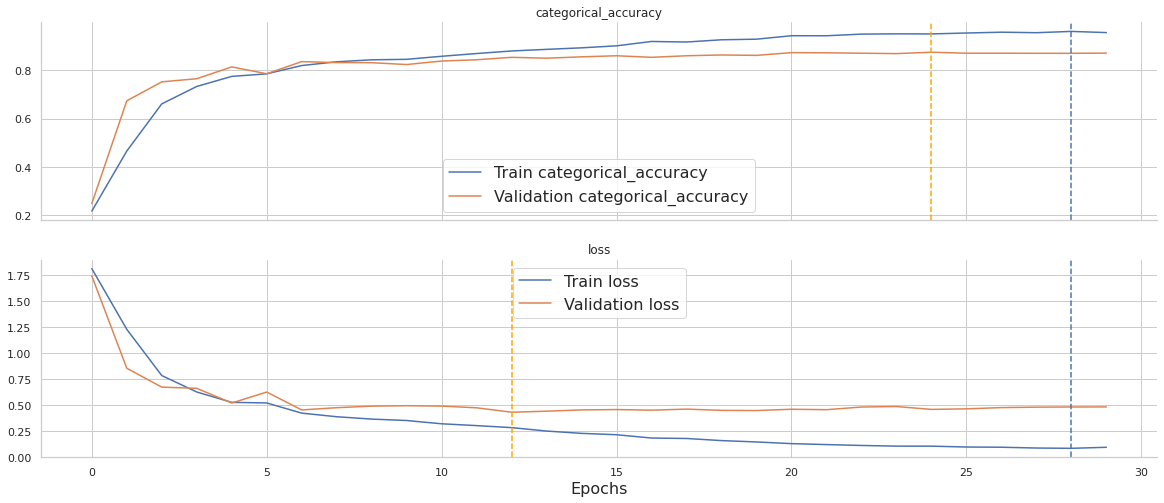


FOLD: 3


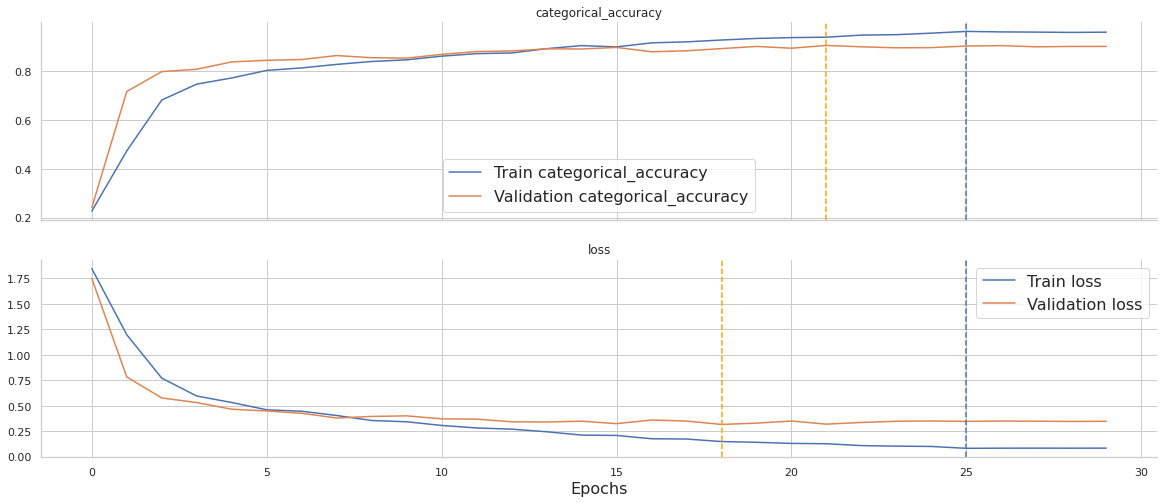


FOLD: 4


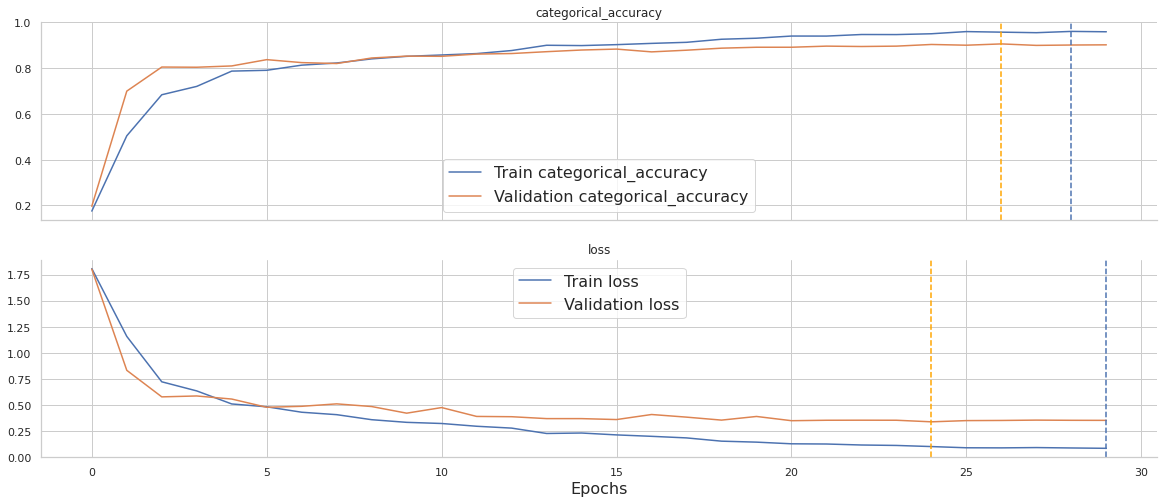


FOLD: 5


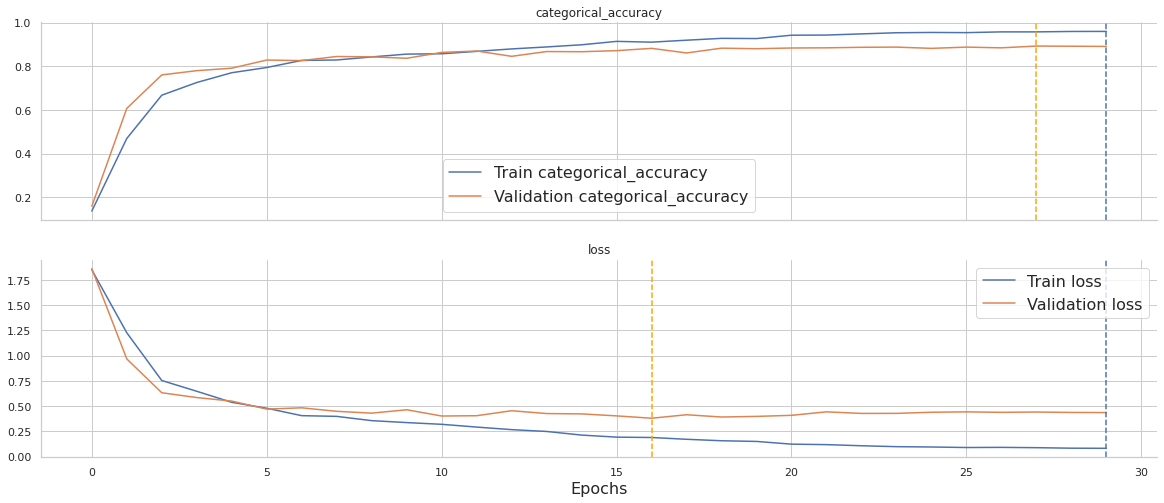

In [20]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

In [21]:
TARGET_NAMES = ["Steel","Adhered","Concrete","Shingle","Plastic & fabric","Ballasted"]

In [22]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)

y_preds = np.argmax(y_preds, axis= 1)
y_true = np.argmax(y_true, axis= 1)

from sklearn.metrics import f1_score
print(f1_score(y_true,y_preds,average='weighted'))
print(classification_report(y_true, y_preds, target_names=TARGET_NAMES))

AxisError: axis 1 is out of bounds for array of dimension 1